# Helpers

In [0]:
import os, sys, wave, struct

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
from math import ceil
from scipy.io import wavfile

# Needed imports
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile

In [0]:
def load_music(file):
    return wave.open(file, 'rb')

def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def process_sound(music) :
    '''
    Process Sound
    '''
    wavefile = load_music(music)
    param = wavefile.getparams()

    Fs, data = wavfile.read(music)
    timestep = 1/float(Fs)
    times = np.arange(len(data))*timestep

    return Fs, data, times, param
  
def write_music_1D(file, param, data):
    '''
    Write Music in wav file (mono)
    '''
    wavefile = wave.open(file, 'wb')
    wavefile.setparams(param)
    wavefile.setnframes(len(data))
    wavefile.setnchannels(1)

    for i in range(len(data)):
        v = int(data[i])
        wavefile.writeframesraw( struct.pack('<h', v ) )
    wavefile.writeframes(''.encode())
    wavefile.close()

# 1 Phasing

## 1.
Program the phasing effect with a(n) following a sinusoidal variation of frequency f a
between the values amin and amax . (One may choose a(n) = B + A sin(2πf a n/F s ) with
B = (amax + amin)/2, A = (amax − amin)/2 and where F s is the sampling frequency).

In [0]:
import numpy as np
from numpy import pi

def phase(x,f,amin,amax,Fs,p):
  
  N = len(x)
  
  A, B = (amax - amin)/2., (amax + amin)/2.
  a = np.array([ B + A*np.sin(2.*pi*f*n/Fs) for n in range(N) ])
  x_pad = np.pad(x, [(p,0)], 'constant', constant_values=(0,0))
  
  y = (x + a*x_pad[:N]).astype(int)
      
  return y

## 2. 
Test the effect with different values of f a , amax and amin (remember that values of a
close to a = 1 give the strongest effect)

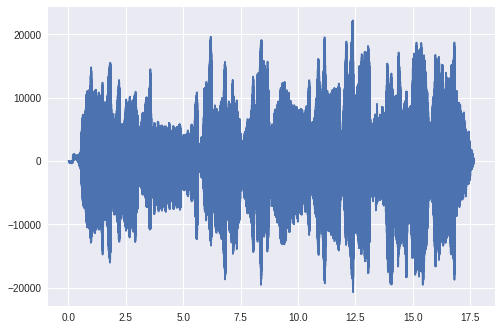

In [4]:
sound = 'paganini.wav'
Fs, data, times, param = process_sound(sound)

plt.plot(times, data)
plt.show()

Audio(data,rate = Fs)

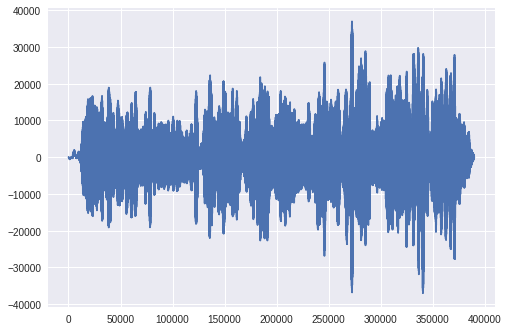

In [13]:
p = int(Fs/500.)  #number of sample differences between the original sound x and x*a 
freq = 5  #frequency of the sinusoid a
amin, amax = -1., 1.  #amplitude of sinusoid a

phased_data = phase(data,freq,amin,amax,Fs,p)

wavfile.write('phased_data.wav',Fs,phased_data)

plt.plot(phased_data)
plt.plot()

Audio(phased_data,rate = Fs)

# 2 Flanger

## 1. 
Write the filter recurrent equation

In [0]:
def flanger(x,f,pmin,pmax,Fs):
  
  N = len(x)
  range_N = range(N)
  
  A, B = (pmax - pmin)/2., (pmax + pmin)/2.
  p = np.array([ B + A*np.sin(2.*pi*f*n/Fs) for n in range_N ])

  x_pad = np.pad(x, [(N,0)], 'constant', constant_values=(0,0))
  
  y = [x[n] + x_pad[int(p[n])] for n in range_N]
      
  return y

In [15]:
pmin, pmax = -100., 100. #now p varies through time, and a=1 is constant
freq = 2 #frequency of variation of the sinusoid ^p

flanged_data = flanger(data,freq,pmin,pmax,Fs)

wavfile.write('phased_data.wav',Fs,phased_data)

Audio(phased_data,rate = Fs)

# 3 Artificial reverberation

## 3.1 Early echoes simulation

### 1. What can be done to improve the realism of the model for a real room?

Higher order echoes could be added.

Maybe choose a more elaborate model for sound dissipation.

Take into account the reverberation of the sound on the object itself (when it bounces back from the wall).

### 2. How many image sources would you have if you include second order echoes?

Counting only the 6 walls, there would be $5 \times 6 = 30$ second order echoes (each sound reverberated on a wall hits the 5 other walls).

### 3. In your opinion, is it necessary to include higher order echoes? justify your answer

No, the human ear hardly perceives second order echoes, let alone higher order ones.

## 3.2 Late reverberation: Schroeder reverberator

### 1. Knowing that it is better that each comb filter cell (resp. all-pass filters) has the same reverberation time, give the gain gi which correspond to the following delays givne in 3 milliseconds (29,7 ms; 37,1 ms; 41,4 ms; 43,7 ms fro comb filters and 96,83 ms and 32,92 ms for all pass filters) as a function of the reverberation time

$\bullet$ For a comb filter, we have $g_i = 10^{-\frac{3 m_i T}{Tr}}$

$\bullet$ For an all-pass filter, we have $g_i = \big(\frac{Tr - 7T}{Tr} \big)^{m_i}$

Replacing $m_i$ by the given values results in the value of the gain as a function of $Tr$

In [0]:
def transform_m(m,Fs): #transform m in miliseconds to number of samples
  return int(Fs*m/1000.)

def make_gi_comb(mi,T,Tr,Fs):  #compute g_i for comb filter
  
  gi = 10**(-3.*mi*T/Tr)
  return gi

def make_gi_all_pass(mi,T,Tr,Fs):  #compute g_i for all-pass filter
  
  gi = ( (Tr - 7*T)/Tr )**mi
  return gi

### 2. Program and test your Schroeder reverberator on one of the given test signal for different room dimensions.


For a comb filter, the transfer function is given by $c(z) = \frac{y(z)}{x(z)} = \frac{z^{-m}}{1 - gz^{-m}} \Leftrightarrow (1 - gz^{-m})y(z) =  z^{-m}x(z)$

Doing the $z$ transform on each side gives: $y[n] = x[n-m] + g.y[n-m]$

We can therefore compute y recursively by padding its $m$ first entries with 0 and keeping only the last entries.

Using the same argument, for an all-pass filter we have :
$y[n] = x[n-m] + g.y[n-m] - gx[n]$

In [0]:
def comb(x,g,m):
  
  N = len(x)
  y = np.zeros(N + m)
  
  for n in range(N):
    n += m
    y[n] = g*y[n-m] + x[n-m]

  return y[-N:]

def all_pass(x,g,m):
  
  N = len(x)
  y = np.zeros(N + m)
  x_pad = np.pad(x, [(m,0)], 'constant', constant_values=(0,0))
  
  for n in range(N):
    n += m 
    y[n] = g*y[n-m] + x_pad[n-m] - g*x_pad[n]
    
  return y[-N:]
  
def Schroeder(x,m_comb,m_all_pass,g_comb,g_all_pass):
  
  y = 0
  for i in range(4):
    y += comb(x,g_comb[i],m_comb[i])
  
  for i in range(2):
    y = all_pass(y,g_all_pass[i],m_all_pass[i])
    
  return np.array(y).astype(int)

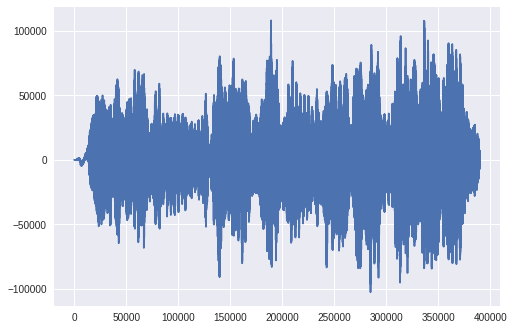

In [10]:
T = 1./float(Fs)
Tr = 0.5  #reverb time corresponding to a big room

m_comb = [29.7, 37.1, 41.4, 43.8]
m_all_pass = [96.83, 32.92]

#transforms m_is as number of samples
mi_comb = [transform_m(m,Fs) for m in m_comb]
mi_all_pass = [transform_m(m,Fs) for m in m_all_pass]

#compute g_is
gi_comb = [make_gi_comb(m,T,Tr,Fs) for m in mi_comb]
gi_all_pass = [make_gi_all_pass(m,T,Tr,Fs) for m in mi_all_pass]

reverb_data = Schroeder(data,mi_comb,mi_all_pass,gi_comb,gi_all_pass)
plt.plot(reverb_data)
plt.show()
Audio(reverb_data,rate = Fs)